In [1]:
import os
import subprocess
from pathlib import Path

import numpy as np

# Data preprocessing

In [2]:
path_to_data1='/media/carmelocuenca/My Passport/10_CASOS/CrossSectionsRamificaciones/HDR'
path_to_data2='/media/carmelocuenca/My Passport/10_CASOS/data'


In [3]:
for directory in os.listdir(path_to_data1):
    print(directory)
    for file in Path(path_to_data1 + '/' + directory).glob('*.bmp'):
        x = np.random.randint(10)
        
        dir = 'train'
        if x == 8 or x == 9:
            dir = 'test'
        else:
            if x == 7:
                dir = 'validation'
        # subprocess.run(["cp", str(file), path_to_data2 + '/' + dir + '/' + directory + '/'])

Abdominal
Arch
Heart
Rest


In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

batch_size = 128

data_generator = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=False,
        vertical_flip=False)

data_gen_args = dict(target_size=(100, 100),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    seed=42)

train_generator = data_generator.flow_from_directory(
    directory=path_to_data2 + '/' + 'train/',
    shuffle=True,
    **data_gen_args)
valid_generator = data_generator.flow_from_directory(
    directory=path_to_data2 + '/' + 'validation/',
    shuffle=False,
    **data_gen_args)
test_generator = data_generator.flow_from_directory(
    directory=path_to_data2 + '/' + 'test/',
    shuffle=False,
    **data_gen_args)

Using TensorFlow backend.


Found 43445 images belonging to 4 classes.
Found 6349 images belonging to 4 classes.
Found 12403 images belonging to 4 classes.


In [5]:
from sklearn.utils import compute_class_weight
class_weight = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
print("class_weight: ", class_weight)

class_weight:  [1.15471508 1.19960791 4.06028037 0.48683326]


In [6]:
from unet import build_classifier

In [7]:
model = build_classifier(features_root=32, layers=3, input_shape=(100, 100, 1), classes=len(os.listdir(path_to_data1)))
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [8]:
# Fitting/Training the model

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from datetime import datetime

log_dir = '/home/carmelocuenca/Documentos/unet/logs/' +  datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
callbacks=[
    TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=False, write_images=False),
    EarlyStopping(patience=8, verbose=1),
    ModelCheckpoint('/home/carmelocuenca/Documentos/unet/hdf5s/' + 'unet' + '.hdf5', 
                    verbose=1, save_best_only=True),]

h = model.fit_generator(train_generator,
                    steps_per_epoch=(len(train_generator.classes)+batch_size-1)//batch_size,
                    validation_data=valid_generator,
                    validation_steps=(len(valid_generator.classes)+batch_size-1)//batch_size,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1,
                    epochs=1024)

Instructions for updating:
Use the retry module or similar alternatives.
Epoch 1/1024
340/340 [==============================] - 76s 225ms/step - loss: 0.4082 - categorical_accuracy: 0.9358 - val_loss: 0.2980 - val_categorical_accuracy: 0.9831

Epoch 00001: val_loss improved from inf to 0.29796, saving model to /home/carmelocuenca/Documentos/unet/hdf5s/unet.hdf5
Epoch 2/1024
340/340 [==============================] - 73s 214ms/step - loss: 0.1661 - categorical_accuracy: 0.9954 - val_loss: 0.1420 - val_categorical_accuracy: 0.9957

Epoch 00002: val_loss improved from 0.29796 to 0.14201, saving model to /home/carmelocuenca/Documentos/unet/hdf5s/unet.hdf5
Epoch 3/1024
340/340 [==============================] - 73s 216ms/step - loss: 0.0926 - categorical_accuracy: 0.9991 - val_loss: 0.1098 - val_categorical_accuracy: 0.9980

Epoch 00003: val_loss improved from 0.14201 to 0.10982, saving model to /home/carmelocuenca/Documentos/unet/hdf5s/unet.hdf5
Epoch 4/1024
340/340 [=====================

# Test data validation

In [9]:
# Predict the output
test_generator.reset()
y_pred = model.predict_generator(test_generator, verbose=1)

97/97 [==============================] - 7s 76ms/step


In [10]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1), labels=range(0, len(os.listdir(path_to_data1))))
print(C/C.astype(np.float).sum(axis=1))

[[1.         0.         0.         0.        ]
 [0.         0.99728787 0.         0.0010958 ]
 [0.         0.         1.         0.        ]
 [0.00340651 0.00154979 0.01262626 0.9963995 ]]


# SOM Zone

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 96, 96, 32)        0         
__________

In [13]:
from keras.models import Model
test_generator.reset()
layer_name = 'activation_7'

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict_generator(test_generator, verbose=1)

97/97 [==============================] - 7s 72ms/step


In [15]:
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [16]:
# data normalization
intermediate_output = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, intermediate_output)

# Initialization and training
som = MiniSom(7, 7, intermediate_output.shape[1], sigma=3, learning_rate=0.5, 
              neighborhood_function='triangle', random_seed=10)
#som.random_weights_init(data)
som.pca_weights_init(intermediate_output)
print("Training...")
som.train_random(intermediate_output, 4*1024)  # random training
print("\n...ready!")

Training...

...ready!


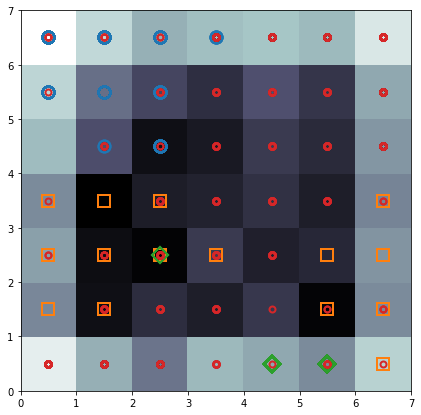

In [17]:
plt.figure(figsize=(7, 7))
# Plotting the response for each pattern in the iris dataset
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
#plt.colorbar()

target = list(test_generator.class_indices.keys())
t = test_generator.classes

# use different colors and markers for each label
markers = ['o', 's', 'D', '.']
colors = ['C0', 'C1', 'C2', 'C3']
for cnt, xx in enumerate(intermediate_output):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[t[cnt]], markerfacecolor='None',
             markeredgecolor=colors[t[cnt]], markersize=12, markeredgewidth=2)
plt.axis([0, 7, 0, 7])
plt.savefig('resulting_images/som.png')
plt.show()

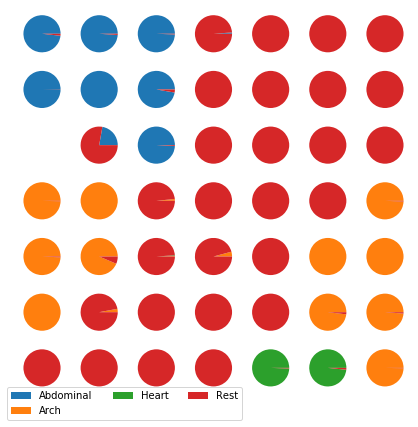

In [42]:
labels = np.array(list(test_generator.class_indices.keys()))[test_generator.classes]  # labels
labels_map = som.labels_map(intermediate_output, labels)
label_names = np.unique(labels)

plt.figure(figsize=(7, 7))
the_grid = GridSpec(7, 7)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_names, bbox_to_anchor=(0, -1), ncol=3)
plt.savefig('resulting_images/som_iris_pies.png')
plt.show()
